In [ ]:
!pip install qiskit_finance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.stats.mstats import gmean


optimization_criterion = 'cvar'

symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
start_date = '2018-01-01'
end_date = '2023-01-01'
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()


[*********************100%%**********************]  4 of 4 completed


In [ ]:
data

Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-01-02,40.670963,59.450500,53.250000,80.080917
2018-01-03,40.663895,60.209999,54.124001,80.453613
2018-01-04,40.852764,60.479500,54.320000,81.161705
2018-01-05,41.317902,61.457001,55.111500,82.167961
2018-01-08,41.164429,62.343498,55.347000,82.251808
...,...,...,...,...
2022-12-23,130.959946,85.250000,89.809998,236.195007
2022-12-27,129.142456,83.040001,87.930000,234.443802
2022-12-28,125.179688,81.820000,86.459999,232.039612


In [ ]:
# Define classical mean-variance optimization function
def classical_mean_variance(data):
    returns = np.log(data / data.shift(1))
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Objective function to minimize - portfolio volatility
    def objective(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Constraint: weights sum up to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for _ in range(len(data.columns)))

    # Initial guess for weights: equal weights
    initial_weights = np.array([1.0 / len(data.columns)] * len(data.columns))

    # Perform optimization
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

    # Extract optimal weights
    optimal_weights = result.x

    return optimal_weights

# Define tickers, start date, and end date
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Example tickers
start_date = '2020-01-01'
end_date = '2022-01-01'


# Perform classical mean-variance optimization
optimal_weights = classical_mean_variance(data)

# Print results
print("Optimal Portfolio Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")


Optimal Portfolio Weights:
AAPL: 0.2361
MSFT: 0.1147
GOOGL: 0.3476
AMZN: 0.3015


In [ ]:
returns = data.pct_change()
returns


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,-0.000174,0.012775,0.016413,0.004654
2018-01-04,0.004645,0.004476,0.003621,0.008801
2018-01-05,0.011386,0.016163,0.014571,0.012398
2018-01-08,-0.003714,0.014425,0.004273,0.001020
...,...,...,...,...
2022-12-23,-0.002798,0.017425,0.017562,0.002267
2022-12-27,-0.013878,-0.025924,-0.020933,-0.007414
2022-12-28,-0.030685,-0.014692,-0.016718,-0.010255


In [ ]:
# Calculate mu (mean)
mu = returns.mean()

# Calculate sigma (covariance)
sigma = returns.cov()

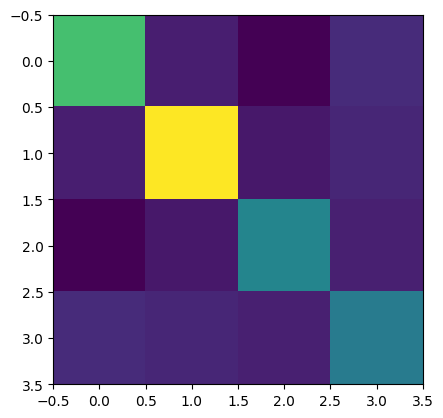

In [ ]:
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [ ]:
from qiskit_finance.applications.optimization import PortfolioOptimization


In [ ]:
num_assets=len(data.columns)
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu.values, covariances=sigma.values, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00022246993996648024*x_0^2 + 0.00031019306194230..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [ ]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [ ]:
from qiskit_algorithms import NumPyEigensolver, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.result import QuasiDistribution

In [ ]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)



Optimal: selection [1. 0. 0. 1.], value -0.0015

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0015		1.0000


In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit.Aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 23.6 MB/s eta 0:00:00


In [ ]:
!pip install qiskit_algorithms

In [ ]:
!pip install cvxportfolio
import cvxportfolio as cp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.0/346.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


<QuadraticProgram: minimize 0.00022247002722540203*x_0^2 + 0.00031019316209197..., 5 variables, 1 constraints, 'Portfolio optimization'>

In [ ]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [ ]:
!pip install cvxportfolio

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
from  qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)




Optimal: selection [1. 0. 0. 1.], value -0.0015

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0015		0.7577
 [0 0 1 1]	-0.0010		0.1370
 [1 1 0 0]	-0.0009		0.0844
 [0 1 1 0]	-0.0004		0.0207
 [0 1 0 0]	-0.0003		0.0001
 [1 1 1 0]	-0.0007		0.0001
 [1 0 1 0]	-0.0010		0.0000
 [0 1 1 1]	-0.0006		0.0000
 [0 0 1 0]	-0.0004		0.0000
 [0 0 0 1]	-0.0009		0.0000
 [1 0 1 1]	-0.0013		0.0000
 [1 1 0 1]	-0.0011		0.0000
 [1 0 0 0]	-0.0009		0.0000
 [0 0 0 0]	0.0000		0.0000
 [0 1 0 1]	-0.0008		0.0000
 [1 1 1 1]	-0.0006		0.0000


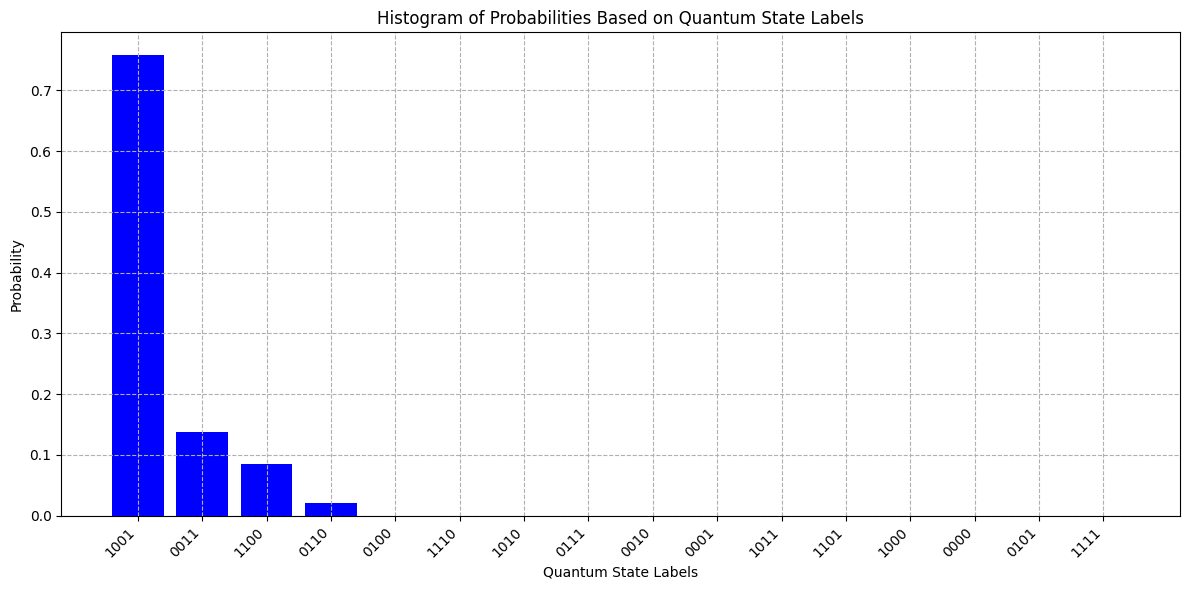

In [ ]:
import matplotlib.pyplot as plt

data = [
    ([1, 0, 0, 1], 0.7577),
    ([0, 0, 1, 1], 0.1370),
    ([1, 1, 0, 0], 0.0844),
    ([0, 1, 1, 0], 0.0207),
    ([0, 1, 0, 0], 0.0001),
    ([1, 1, 1, 0], 0.0001),
    ([1, 0, 1, 0], 0.0000),
    ([0, 1, 1, 1], 0.0000),
    ([0, 0, 1, 0], 0.0000),
    ([0, 0, 0, 1], 0.0000),
    ([1, 0, 1, 1], 0.0000),
    ([1, 1, 0, 1], 0.0000),
    ([1, 0, 0, 0], 0.0000),
    ([0, 0, 0, 0], 0.0000),
    ([0, 1, 0, 1], 0.0000),
    ([1, 1, 1, 1], 0.0000)
]

states = ["".join(map(str, state)) for state, _ in data]
probabilities = [prob for _, prob in data]

plt.figure(figsize=(12, 6))
plt.bar(states, probabilities, color='blue')
plt.xlabel('Quantum State Labels')
plt.ylabel('Probability')
plt.title('Histogram of Probabilities Based on Quantum State Labels')

plt.xticks(rotation=45, ha='right')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()



In [ ]:
!pip install qiskit_ibm_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.9 MB/s eta 0:00:00
  Created wheel for ibm-platform-services: filename=ibm_platform_services-0.52.0-py3-none-any.whl size=331902 sha256=ef6c342f3b560490df1208ce81ff37e0685c6fbcfef4fb0e25896d8cfe1748f4
  Stored in directory: /root/.cache/pip/wheels/9b/34/7b/f02968953b977f20d07a36eab5f7ea8c4d6590f5919940a9f8
  Created wheel for ibm-cloud-sdk-

In [ ]:
!pip install qiskit_ibm_provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.6/249.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.2 MB/s eta 0:00:00


In [ ]:
import qiskit_ibm_runtime

In [ ]:
import qiskit_aer as Aer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_ibm_provider.job import job_monitor
from qiskit import transpile
from qiskit_algorithms import VQE
import qiskit_ibm_provider
from qiskit.circuit import Parameter
from qiskit_ibm_provider import IBMProvider

# Load IBM Quantum account
provider = IBMProvider(token='535cd063a26631b866c9a60b3864e1d4f44d298bfc643ea05f093f87103a2df73f479eda63765d4d421eab73e95f76b20eb10a98f5a3ec933234ea0e13f9ac42')

# Set the backend where you want to run the circuit
backend = provider.get_backend('ibm_brisbane')

# Define the number of assets
num_assets = 4  # You need to define the number of assets based on your problem


params = [Parameter(f'theta_{i}') for i in range(2 * num_assets + 1)]

# Set the COBYLA optimizer
cobyla = COBYLA(maxiter=500)

# Define the ansatz
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full", insert_barriers=True, parameter_prefix='theta')

# Bind parameters
from qiskit import transpile
bound_ry = transpile(ry, backend)
bound_ry = bound_ry.assign_parameters({p: 0.01 for p in params})


CircuitError: 'Cannot bind parameters (theta_1, theta_0, theta_4, theta_7, theta_5, theta_8, theta_3, theta_2, theta_6) not present in the circuit.'

In [ ]:
# Define the VQE algorithm
# Define the VQE algorithm
vqe = VQE(ansatz=ry, optimizer=cobyla, estimator=provider.get_backend('ibm_brisbane'))

# Transpile the circuit
transpiled_circuit = transpile(vqe.ansatz, backend)

# Execute the circuit on the backend
job = backend.run(transpiled_circuit)

# Monitor the job
job_monitor(job)

# Get the result
result = job.result()

# Print the result
print(result)


Job Status: ERROR - QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15])])]


IBMJobFailureError: "Job failed: QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15])])]"

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal


# Define the number of assets
num_assets = 4

# Define the ansatz circuit
ansatz = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")

# Define the VQE algorithm with COBYLA optimizer

# Define a classical optimizer (just for simplicity)
classical_optimizer = NumPyMinimumEigensolver()

# Create a MinimumEigenOptimizer
minimum_eigen_optimizer = MinimumEigenOptimizer(vqe, classical_optimizer)

# Create a Quantum Circuit to get the state from the Ansatz
qc = QuantumCircuit(ansatz.num_qubits)




In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=118567081996bdc02f0a58d1de3572e857d571f676cd2297f522583bdf6cca92
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [ ]:

# Define quantum mean-variance optimization function using VQE
def quantum_mean_variance(data):
    mu = data.pct_change().mean()
    sigma = data.pct_change().cov()

# Ensure mu is a one-dimensional array or pandas Series
    if isinstance(mu, pd.DataFrame):
      mu = mu.values.flatten()
    elif isinstance(mu, pd.Series):
      mu = mu.values

# Ensure sigma is a two-dimensional array or pandas DataFrame
    if isinstance(sigma, pd.Series):
      sigma = sigma.to_frame()
    if isinstance(sigma, pd.DataFrame):
      sigma = sigma.values

# Check if the lengths match
    if len(mu) != len(sigma):
      raise ValueError("Sizes of expected_returns and covariances do not match.")

    num_assets = len(data.columns)
    q = 0.5  # set risk factor
    budget = num_assets // 2  # set budget
    penalty = num_assets
    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
    )
    qp = portfolio.to_quadratic_program()

    # Convert to QUBO
    qubo_converter = QuadraticProgramToQubo(penalty=penalty)
    qubo = qubo_converter.convert(qp)

    # Define backend simulator
    backend = qiskit_aer.StatevectorSimulator
    # Define optimizer
    optimizer = COBYLA()



    # Define ansatz
    ansatz = TwoLocal(qp.get_num_vars(), ['ry', 'rz'], 'cx', reps=3)

    # Execute VQE
    vqe = VQE(ansatz=ansatz, optimizer=optimizer, estimator=backend)
    result = vqe.compute_minimum_eigenvalue(qubo.to_ising())

    # Retrieve result
    portfolio_weights = portfolio.sample_most_likely(result.eigenstate)
    portfolio_value = portfolio.portfolio_value(portfolio_weights, mu, sigma, q)
    return portfolio_weights, portfolio_value
    # Define optimizer
    optimizer = COBYLA()

    return qubo, backend, optimizer


In [ ]:
from qiskit_optimization.converters import QuadraticProgramToQubo

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2018-01-02,40.670971,59.450500,53.660500,80.080917
2018-01-03,40.663902,60.209999,54.576000,80.453590
2018-01-04,40.852783,60.479500,54.787998,81.161705
2018-01-05,41.317902,61.457001,55.514500,82.167969
2018-01-08,41.164433,62.343498,55.710499,82.251816
...,...,...,...,...
2022-12-23,130.959961,85.250000,89.230003,236.195023
2022-12-27,129.142456,83.040001,87.389999,234.443817
2022-12-28,125.179672,81.820000,86.019997,232.039627


AttributeError: 'tuple' object has no attribute 'num_qubits'

In [ ]:
!pip install qiskit_ibm_provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.6/249.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.6 MB/s eta 0:00:00


TypeError: VQE.__init__() missing 1 required positional argument: 'optimizer'

  Preparing metadata (setup.py) ... done
  Created wheel for qiskit_utils: filename=qiskit_utils-1.2.1-py3-none-any.whl size=6544 sha256=489da31484d1338414569f93cb4c545c9d582997002c4fbb96141a432a18cc49
  Stored in directory: /root/.cache/pip/wheels/53/4a/ad/77d3cd72c62e79da4e674b809e43b0e576d630e53f3870f4d9
Successfully built qiskit_utils
